In [1]:
import pandas as pd
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import numpy as np
import nltk
import random
import logging

In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
from nltk.corpus import stopwords
# nltk.download("stopwords")
# nltk.download('punkt')
stop = set(stopwords.words('english'))

In [10]:
def get_words(question) :
    return list(filter(lambda word: word not in stop and word.isalpha(), nltk.word_tokenize(question.lower())))

getLabeledSentence = lambda given_tuple: [
             LabeledSentence(get_words(given_tuple[0]),["question1_"+str(given_tuple[2])]),  
             LabeledSentence(get_words(given_tuple[1]),["question2_"+str(given_tuple[2])])]

flatten = lambda l: [item for sublist in l for item in sublist]

In [82]:
traindf = pd.read_csv('train.csv')
traindf['index1'] = traindf.index
traindf = traindf.fillna("")
traindf.shape

(404290, 7)

In [83]:
testdf = pd.read_csv('train.csv')
testdf = testdf.fillna("")
testdf.shape

(404290, 6)

In [130]:
traindf = traindf[:1000]
testdf = testdf[:1000]

train_df_size = traindf.shape[0]
test_df_size = testdf.shape[0]

In [85]:
trainSentences = flatten(list(map(lambda x: getLabeledSentence(x) , traindf[['question1', 'question2', 'id']].values)))

In [86]:
testSentences = flatten(list(map(lambda x: getLabeledSentence(x) , testdf[['question1', 'question2', 'id']].values)))

In [87]:
sentences = trainSentences + testSentences
len(sentences)

4000

In [88]:
model = Doc2Vec(min_count=1, window=10, size=1000, sample=1e-4, negative=5, workers=8)

In [89]:
model.build_vocab(sentences)

2017-04-21 16:40:21,032 : INFO : collecting all words and their counts
2017-04-21 16:40:21,034 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-04-21 16:40:21,080 : INFO : collected 3594 word types and 2000 unique tags from a corpus of 4000 examples and 20460 words
2017-04-21 16:40:21,081 : INFO : Loading a fresh vocabulary
2017-04-21 16:40:21,096 : INFO : min_count=1 retains 3594 unique words (100% of original 3594, drops 0)
2017-04-21 16:40:21,097 : INFO : min_count=1 leaves 20460 word corpus (100% of original 20460, drops 0)
2017-04-21 16:40:21,145 : INFO : deleting the raw counts dictionary of 3594 items
2017-04-21 16:40:21,146 : INFO : sample=0.0001 downsamples 946 most-common words
2017-04-21 16:40:21,147 : INFO : downsampling leaves estimated 13709 word corpus (67.0% of prior 20460)
2017-04-21 16:40:21,148 : INFO : estimated required memory for 3594 words and 1000 dimensions: 38949000 bytes
2017-04-21 16:40:21,174 : INFO : resetting layer weig

In [90]:
for epoch in range(10):
    random.shuffle(sentences)
    model.train(sentences)

2017-04-21 16:40:22,738 : INFO : training model with 8 workers on 3594 vocabulary and 1000 features, using sg=0 hs=0 sample=0.0001 negative=5 window=10
2017-04-21 16:40:22,740 : INFO : expecting 4000 sentences, matching count from corpus used for vocabulary survey
2017-04-21 16:40:24,276 : INFO : PROGRESS: at 9.79% examples, 5677 words/s, in_qsize 10, out_qsize 0
2017-04-21 16:40:24,323 : INFO : worker thread finished; awaiting finish of 7 more threads
2017-04-21 16:40:24,329 : INFO : worker thread finished; awaiting finish of 6 more threads
2017-04-21 16:40:24,339 : INFO : worker thread finished; awaiting finish of 5 more threads
2017-04-21 16:40:24,343 : INFO : worker thread finished; awaiting finish of 4 more threads
2017-04-21 16:40:24,363 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-04-21 16:40:24,459 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-04-21 16:40:24,711 : INFO : worker thread finished; awaiting finish of 1 more threa

In [131]:
train_data = []
train_labels = []
yaxis = []
for i in range(0, train_df_size):
    x = get_words(traindf.iloc[i].question1)
    y = get_words(traindf.iloc[i].question2)
    if len(x) > 0 and len(y) > 0:
        sim = model.n_similarity(x,y)
    else:
        sim = 0
    train_data.append(sim)
    train_labels.append(traindf.iloc[i].is_duplicate)
    yaxis.append(i)
    
print(len(train_data))
print(len(train_labels))

1000
1000


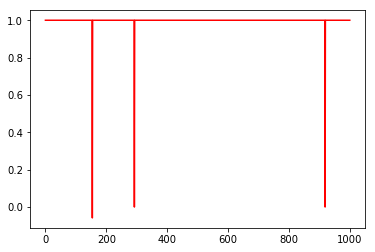

In [119]:
import matplotlib.pyplot as plt

plt.plot(yaxis, train_data, "r")
plt.show()

In [125]:
test_data = np.array(train_data[:500]).reshape(-1,1)
test_labels = np.array(train_labels[:500]).reshape(-1,1)
train_data = np.array(train_data).reshape(-1,1)
train_labels = np.array(train_labels).reshape(-1,1)

In [126]:
from sklearn.neural_network import MLPClassifier

In [127]:
clfNN = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

In [128]:
clfNN.fit(train_data, train_labels)

/home/indix/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:904: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [129]:
clfNN.score(test_data, test_labels)

0.624

In [132]:
testId = []
test_similarity = []
for i in range(0, test_df_size):
    x = get_words(testdf.iloc[i].question1)
    y = get_words(testdf.iloc[i].question2)
    if len(x) > 0 and len(y) > 0:
        sim = model.n_similarity(x,y)
    else:
        sim = 0
    testId.append(i)
    test_similarity.append(sim)

In [133]:
test_similarity

[0.99999423775390306,
 0.99997759268055209,
 0.99998858746352914,
 0.9999585412607227,
 0.99999146344523981,
 0.99999673049152416,
 0.99995398363802313,
 0.99993890611517255,
 0.99999686597531279,
 0.99998876816180449,
 0.99997121634044728,
 0.99998973226748533,
 1.0000000000000002,
 0.99999652512791715,
 0.99999895756390467,
 0.99999087085595484,
 0.99995758755412656,
 0.99998487735408048,
 0.99999597657144368,
 0.9999933028407213,
 0.99999243769342705,
 0.99999233824079181,
 0.99999081038744309,
 0.99996477141238738,
 0.99998546540985478,
 0.99999774756392135,
 0.99999503235564402,
 0.99998608478215423,
 0.99999697942607157,
 0.99999333841044125,
 0.99999453226316437,
 0.9999928705231117,
 0.99999710671513675,
 0.99994616980417927,
 0.99999846739911091,
 0.99999191962443679,
 0.99999213998411518,
 0.99998068106254467,
 0.99997156598833803,
 0.99998445975448813,
 0.99991530086872948,
 1.0000000000000002,
 1.0000000000000002,
 0.99998768647995018,
 0.99999301949538599,
 0.9999955009559